<a href="https://colab.research.google.com/github/sdinesh01/NLP-assignments/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

Perform an exploratory data analysis of a corpus of documents. The corpus consists of 11,587 documents, each of which is a news article. 

Analyze a corpus of news documents to answer the following:

0. What is the nature of our data?
    - 0a. What is the size of the corpus?
    - 0b. Are there any duplicates in the corpus?
    - 0c. Are there any missing values in the corpus?
    - 0d. How many unique documents are there in the corpus?
1. What is the distribution of `token`s per document?
    - 1a. What is the longest article?
    - 1b. What is the shortest article?
    - 1c. What is the 95th percentile of article lengths?
2. How many different sources are there in the corpus?
    - 2a. How many different sources are there in the dataset?
    - 2b. What is the distribution of articles per source?

In [3]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

## News Corpus

You are provided the following news corpus: `data/news_corpus.csv`. The corpus contains the following columns:

- `index` int: The unique identifier of the document.
- `source` str: The source of the document
- `title` str: The title of the document
- `text` str: The content of the article

The data used in this notebook comes from the [`StoryGraph`](https://archive.org/details/storygraph?tab=about) project, created and maintained by Prof. Alexander Nwala.

```BibTeX
@MISC {nwala-cj20,
    author = {Alexander Nwala and Michele C. Weigle and Michael L. Nelson},
     title = {365 Dots in 2019: Quantifying Attention of News Sources},
     year = {2020},
      month = may,
     howpublished = {Poster/demo accepted at the Computation + Journalism Symposium (symposium cancelled due to COVID-19)},
     arxiv = {https://arxiv.org/abs/2003.09989},
     pubdate = {202005}
}
```

## Load Data into Pandas dataframe

In [1]:
url = 'https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/assignment_notebooks/data/news-2023-02-01.csv'

In [4]:
df = pd.read_csv(url)
df.head(10)

,source,title,text
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...
5,vox,What layoffs at Google and other tech companie...,The path forward for tech workers won’t be eas...
6,vox,Did Republican Representative-elect George San...,New York Representative-elect George Santos sp...
7,vox,Sundance 2023: 17 movies to watch out for this...,Chiwetel Ejiofor and Emilia Clarke in The Pod ...
8,huffpost,Watch Trump Give Deposition In New York Civil ...,Watch Trump Give Deposition In New York Civil ...
9,huffpost,Ron DeSantis Plans To Defund Diversity Program...,Politics Florida Ron DeSantis higher education...


## 0. What is the nature of our data?

Using your coding skills, answer the following questions. Please comment on your code and results.

In [5]:
## 0a. What is the size of the corpus?

#check the size of the database
df.shape

# the corpus contains 11,587 documents

(11587, 3)

In [6]:
## 0b. Are there any duplicates in the corpus? If so, remove or drop them.

# use pd.duplicated to identify duplicate rows on source, title, and text. returns true if the row index is a duplicate
# subset df where df.duplicated is not true, therefore false
df2 = df[~df.duplicated(['title', 'source','text'])]

print(df2.shape)
df2.head()

(1190, 3)


,source,title,text
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...


In [7]:
## 0c. Are there any missing values in the corpus? If so, what data are missing?
## Should the missing values be removed, explain?

# identify where any value in a row is na, and subset the database excluding nan
df = df2[~df2.isna().any(axis=1)]

# I am removing missing values, because the five rows that were identified were all missing the text, which is necessary for token analysis
df.head(7)

,source,title,text
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...
5,vox,What layoffs at Google and other tech companie...,The path forward for tech workers won’t be eas...
6,vox,Did Republican Representative-elect George San...,New York Representative-elect George Santos sp...


## 1.0 What is the distribution of `token`s per document?

Use the `spaCy` library to tokenize the text and analyze the distribution of token frequencies. You can use the `Counter` class from the `collections` library to count the number of times each token appears in the corpus.

In [12]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load the spacy model: nlp
NLP = spacy.load('en_core_web_sm')


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [13]:
## Generate the tokens using Spacy

df['tokens'] = df['text'].progress_apply(lambda x: [x.lemma_.lower() for x in NLP(x) if x.lemma_.lower()])
df

  0%|          | 0/1185 [00:00<?, ?it/s]

<ipython-input-13-bde73febba45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['text'].progress_apply(lambda x: [x.lemma_.lower() for x in NLP(x) if x.lemma_.lower()])


,source,title,text,tokens
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...,"[manhattan, prosecutor, be, likely, to, notice..."
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...,"[print, \n, investigator, look, into, donald, ..."
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...,"[the, ap, report, :, \n, republican, rep., geo..."
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...,"[rachel, maddow, show, how, trump, commit, a, ..."
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...,"[candle, be, place, in, front, of, a, photo, o..."
...,...,...,...,...
11500,thehill,"White House bids farewell to Klain, as Zients ...","White House bids farewell to Klain, as Zients ...","[white, house, bid, farewell, to, klain, ,, as..."
11543,thehill,Lawmakers clash over allowing guns in Natural ...,Lawmakers clash over allowing guns in Natural ...,"[lawmaker, clash, over, allow, gun, in, natura..."
11559,westernjournal,Pizza Shop Employee Gets Rude Awakening After ...,Pizza Shop Employee Gets Rude Awakening After ...,"[pizza, shop, employee, get, rude, awakening, ..."
11560,westernjournal,White House Accused of 'Dishonesty and Evasive...,President Joe Biden boards Air Force One at th...,"[president, joe, biden, board, air, force, one..."


In [15]:
## Count the tokens

corpus_tokens = (df
                  .explode('tokens')
                  .drop(columns=['text'])
                )
# total tokens = 939744
corpus_tokens.shape

(939744, 3)

In [16]:
# remove punctuation from tokens
import string
punctuation = list(string.punctuation)
corpus_tokens = corpus_tokens[~corpus_tokens['tokens'].isin(punctuation)].reset_index().drop(columns='index')
corpus_tokens.shape

# Now 823400 tokens

(823400, 3)

In [17]:
# Add docID to link tokens to their documents
corpus_tokens['docID'] = corpus_tokens.groupby(['title','source']).ngroup()

corpus_tokens.sort_values(by='docID')

,source,title,tokens,docID
98529,thegatewaypundit,"""His Policies Were Incredibly Good for This Co...",after,0
98430,thegatewaypundit,"""His Policies Were Incredibly Good for This Co...",for,0
98431,thegatewaypundit,"""His Policies Were Incredibly Good for This Co...",this,0
98432,thegatewaypundit,"""His Policies Were Incredibly Good for This Co...",country,0
98433,thegatewaypundit,"""His Policies Were Incredibly Good for This Co...",and,0
...,...,...,...,...
429084,thehill,"’48 Hours’ Erin Moriarty talks covering crime,...",some,713
429083,thehill,"’48 Hours’ Erin Moriarty talks covering crime,...",\n,713
429082,thehill,"’48 Hours’ Erin Moriarty talks covering crime,...",piece,713
429088,thehill,"’48 Hours’ Erin Moriarty talks covering crime,...",she,713


In [18]:
import seaborn as sns

In [75]:
## Plot the distribution of the number of tokens per document
df['tokens_len'] = [len(x) for x in df['tokens']]

<ipython-input-75-eca6a8b8d46a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens_len'] = [len(x) for x in df['tokens']]


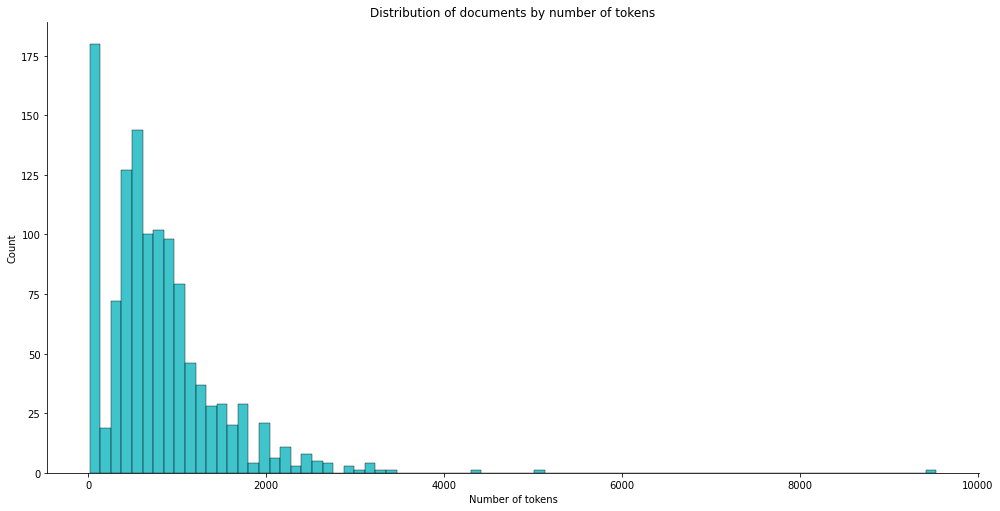

In [82]:
fig = sns.displot(data=df, x='tokens_len', height=7, aspect=2, color='#00B0BA', edgecolor='k', linewidth=0.4
                  ).set(title='Distribution of documents by number of tokens')
fig.set_xlabels('Number of tokens')
plt.show()

In [79]:
## 1a. What is the longest article?
df['tokens_len'].describe()

# the longest article has 9533 tokens

count    1185.000000
mean      793.032911
std       661.112783
min        16.000000
25%       397.000000
50%       676.000000
75%      1031.000000
max      9533.000000
Name: tokens_len, dtype: float64

In [83]:
## 1b. What is the shortest article?
df['tokens_len'].describe()

# the shortest article has 16 tokens

count    1185.000000
mean      793.032911
std       661.112783
min        16.000000
25%       397.000000
50%       676.000000
75%      1031.000000
max      9533.000000
Name: tokens_len, dtype: float64

In [81]:
## 1c. What is the 95th percentile of the number of tokens per document?
## Hint: use np.percentile

np.percentile(df['tokens_len'],95)

1979.8

In [93]:
## 1d. What is the size of the vocabulary and the frequencies of each token in the corpus?

import string
from collections import Counter

## Create list of stopwords from spacy
stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)

# create a word frequency dataframe
term_frequency = (corpus_tokens
                  #sort data by document ID and tokens
                  .groupby(by=['docID', 'tokens'])
                  #count by aggregating tokens together
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  #groupby creates new indices, so reset
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

term_frequency = term_frequency.drop(term_frequency[term_frequency['term'].isin(stop_words)].index)

# compute frequencies of each token in the corpus
counter = Counter(term_frequency['term'])
#print(counter)

#size of the vocabulary
len(counter)

17355

## 2.0 How many different sources are there in the corpus?

Please describe how many different sources exist in the dataset.

In [ ]:
## 2a. Plot how many different sources are there in the corpus?

In [122]:
# retrieve unique sources in the corpus
data = pd.DataFrame(df['source'].value_counts()).reset_index()
data.columns=['source','count']
data.head(3)

,source,count
0,thehill,218
1,westernjournal,212
2,foxnews,106


Text(0.5, 1.0, 'Number of Articles by Source')

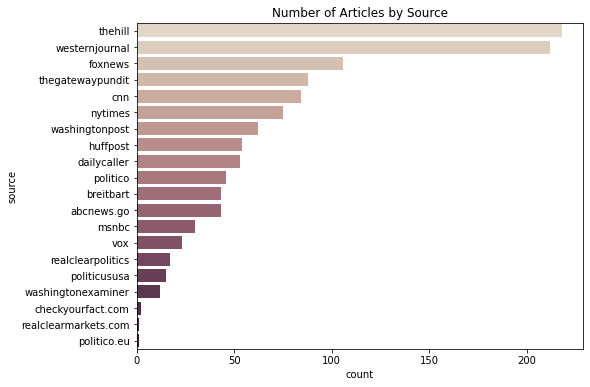

In [201]:
fig = sns.barplot(data=data, x="count",y="source", palette="ch:.25")
plt.rcParams['figure.figsize']=(8,5)
plt.title('Number of Articles by Source')

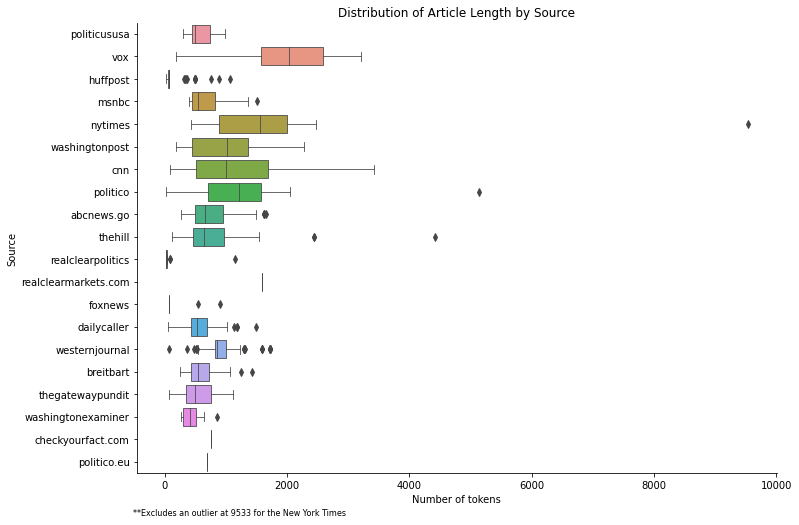

In [198]:
## 2b. Plot the distribution of articles per source?
## hint: use seaborn boxplot
txt = '**Excludes an outlier at 9533 for the New York Times'
fig = sns.catplot(data=df, x="tokens_len", y="source", kind="box", linewidth=0.8,
                  height=7, aspect=1.6)
#plt.xlim(-200,6000)
plt.title('Distribution of Article Length by Source')
plt.xlabel('Number of tokens')
plt.ylabel('Source')
plt.figtext(0.17, 0.00009, txt, wrap=True, horizontalalignment='left', fontsize=8)
plt.rcParams['figure.figsize']=(15,11)